In [1]:
## Import packages here
# Data Management
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import cftime
import glob

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import cartopy
from cartopy import config
import cartopy.crs as ccrs
%matplotlib inline
plt.rcParams['hatch.color'] = 'silver'
plt.rcParams['hatch.linewidth'] = 2

# Statistics
import climlab
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import signal
import seaborn as sns

# Window Display
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings('ignore')

/tmp/ipykernel_17168/3613938809.py:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Load all global constants and global functions
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/data/get_global_constants.ipynb # load global constants
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/data/get_data_variables_fncs.ipynb # load global functions

# Run ONLY to obtain and calculate data variables

In [ ]:
# %run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/data/get_data_variables.ipynb # run functions to obtain raw data
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/data/data_variable_calculator.ipynb # run functions to calculate and save data variables

# DATA LOADING

In [3]:
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/code/data_variable_loader.ipynb # load data variables (if already created)

# Statistical Functions

In [4]:
# perform statsmodels OLS on x and y
def getReg(x,y):
    x_const = sm.add_constant(x.values)
    reg = sm.OLS(y.values,x_const).fit()
        
    return [reg.params,reg.bse]

# get pearson correlation
def getCorr(x,y):
    return st.pearsonr(x.values,y.values)[0]

# use scipy stats to get probability density function
def get_pdf(x,loc,scale):
    return st.norm.pdf(x=x,loc=loc,scale=scale)

# use scipy stats to get kernel density estimate
def get_kde(n,x,params,y):
    x_rv = st.norm(loc=np.mean(x),scale=np.std(x)).rvs(size=n)
    b0_rv = st.norm(loc=params[0][1],scale=params[1][1]).rvs(size=n)
    b1_rv = st.norm(loc=params[0][0],scale=params[1][0]).rvs(size=n)
    
    reg_rv = x_rv*b0_rv + b1_rv
    
    kernel = st.gaussian_kde(reg_rv)
    return kernel(y)

# PLOTTING

### ENSO Feedback Comparison 

This plot is designed to illustrate the differences and similarities between calculating ENSO feedbacks derived from amip and amip-piForcing simulations. For the remainder of this notebook, we use amip simulations for model ENSO feedbacks.

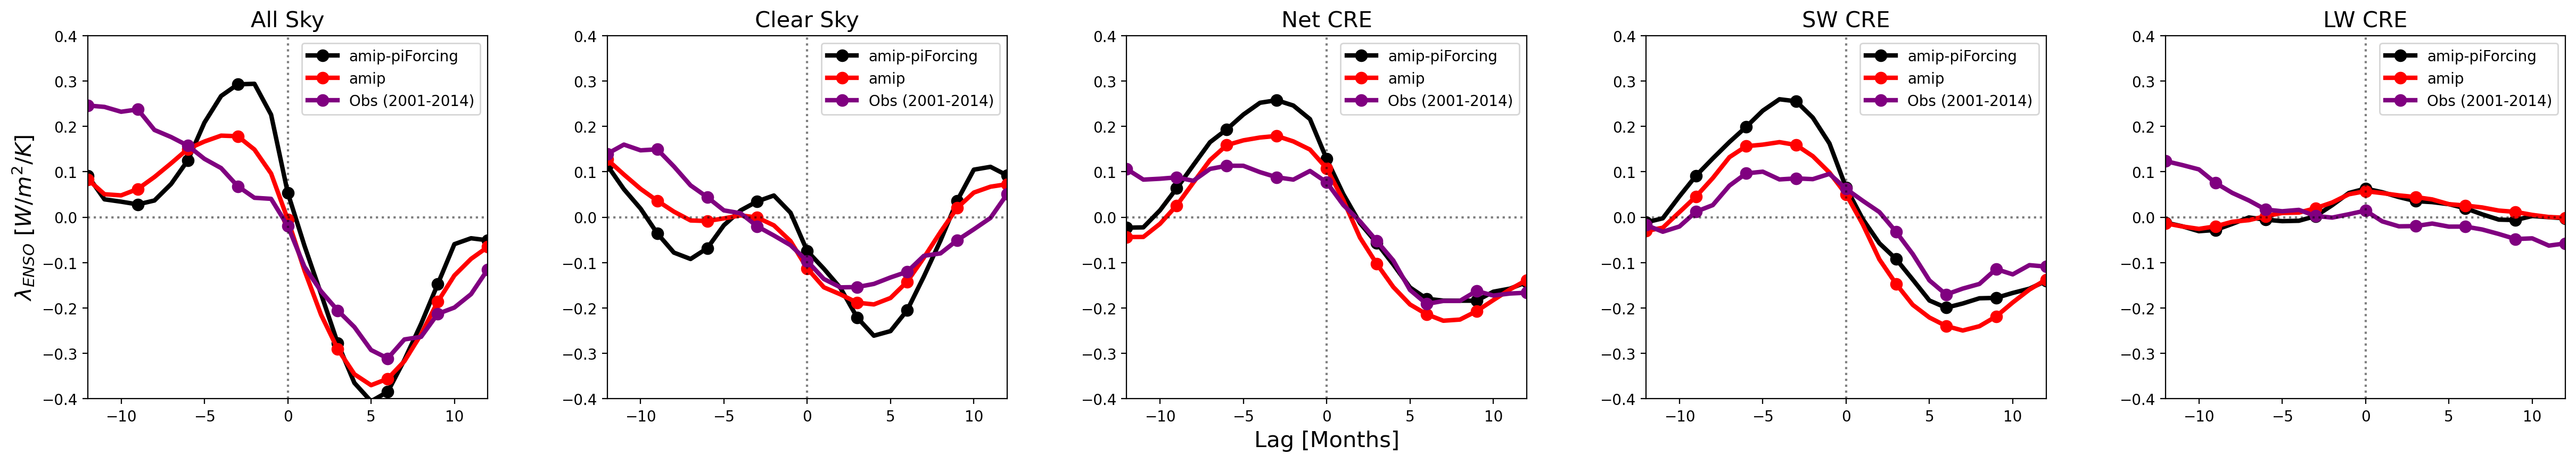

In [45]:
fig, ax = plt.subplots(1,5,figsize=(24,4),dpi=200)
fig.tight_layout(w_pad=5)

data_var = ['all_sky','clr_sky','net_cre','sw_cre','lw_cre']
title = ['All Sky','Clear Sky','Net CRE','SW CRE','LW CRE']
k = 0
for i in data_var:
    # plot ENSO feedbacks derived from amip-piForcing, amip, and observations
    global_mean(ds_e_pF[i]).mean(dim='model').plot(ax=ax[k],color='k',label='amip-piForcing',linewidth=3,marker='.',markevery=3,markersize=15)
    global_mean(ds_e[i]).mean(dim='model').plot(ax=ax[k],color='r',label='amip',linewidth=3,marker='.',markevery=3,markersize=15)
    ds_eo_2014_gm[i].plot(ax=ax[k],color='purple',label='Obs (2001-2014)',linewidth=3,marker='.',markevery=3,markersize=15)

    ax[k].axhline(y=0,linestyle='dotted',color='k',alpha=0.5)
    ax[k].axvline(x=0,linestyle='dotted',color='k',alpha=0.5)
    
    ax[k].legend()
    ax[k].set_title(title[k],size=15)
    ax[k].set_xlim([-12,12])
    ax[k].set_ylim([-0.4,0.4])
    ax[k].set_ylabel(None)
    ax[k].set_xlabel(None)
    
    k = k+1
    
ax[0].set_ylabel('$\lambda_{ENSO}$ [$W/m^2/K$]',size=15)
ax[2].set_xlabel('Lag [Months]',size=15);

### ECS Comparison

This plot is used to demonstrate the differences between calculation of ECS using historical vs equilibrium radiative feedbacks.

In [46]:
# obtained from Zelinka - https://github.com/mzelinka/cmip56_forcing_feedback_ecs/blob/master/CMIP6_ECS_ERF_fbks.txt
forcings = [3.68,3.27,3.64,3.49,3.58,3.65,3.43,3.85]
model_f = xr.DataArray(data=forcings,coords={'model':models})

In [47]:
# ECS calculations
ECS_hist_1870 = -model_f / global_mean(ds_h_1870.all_sky)
ECS_hist_1979 = -model_f / global_mean(ds_h_1979.all_sky)
ECS_eq = -model_f / global_mean(ds_a.all_sky)

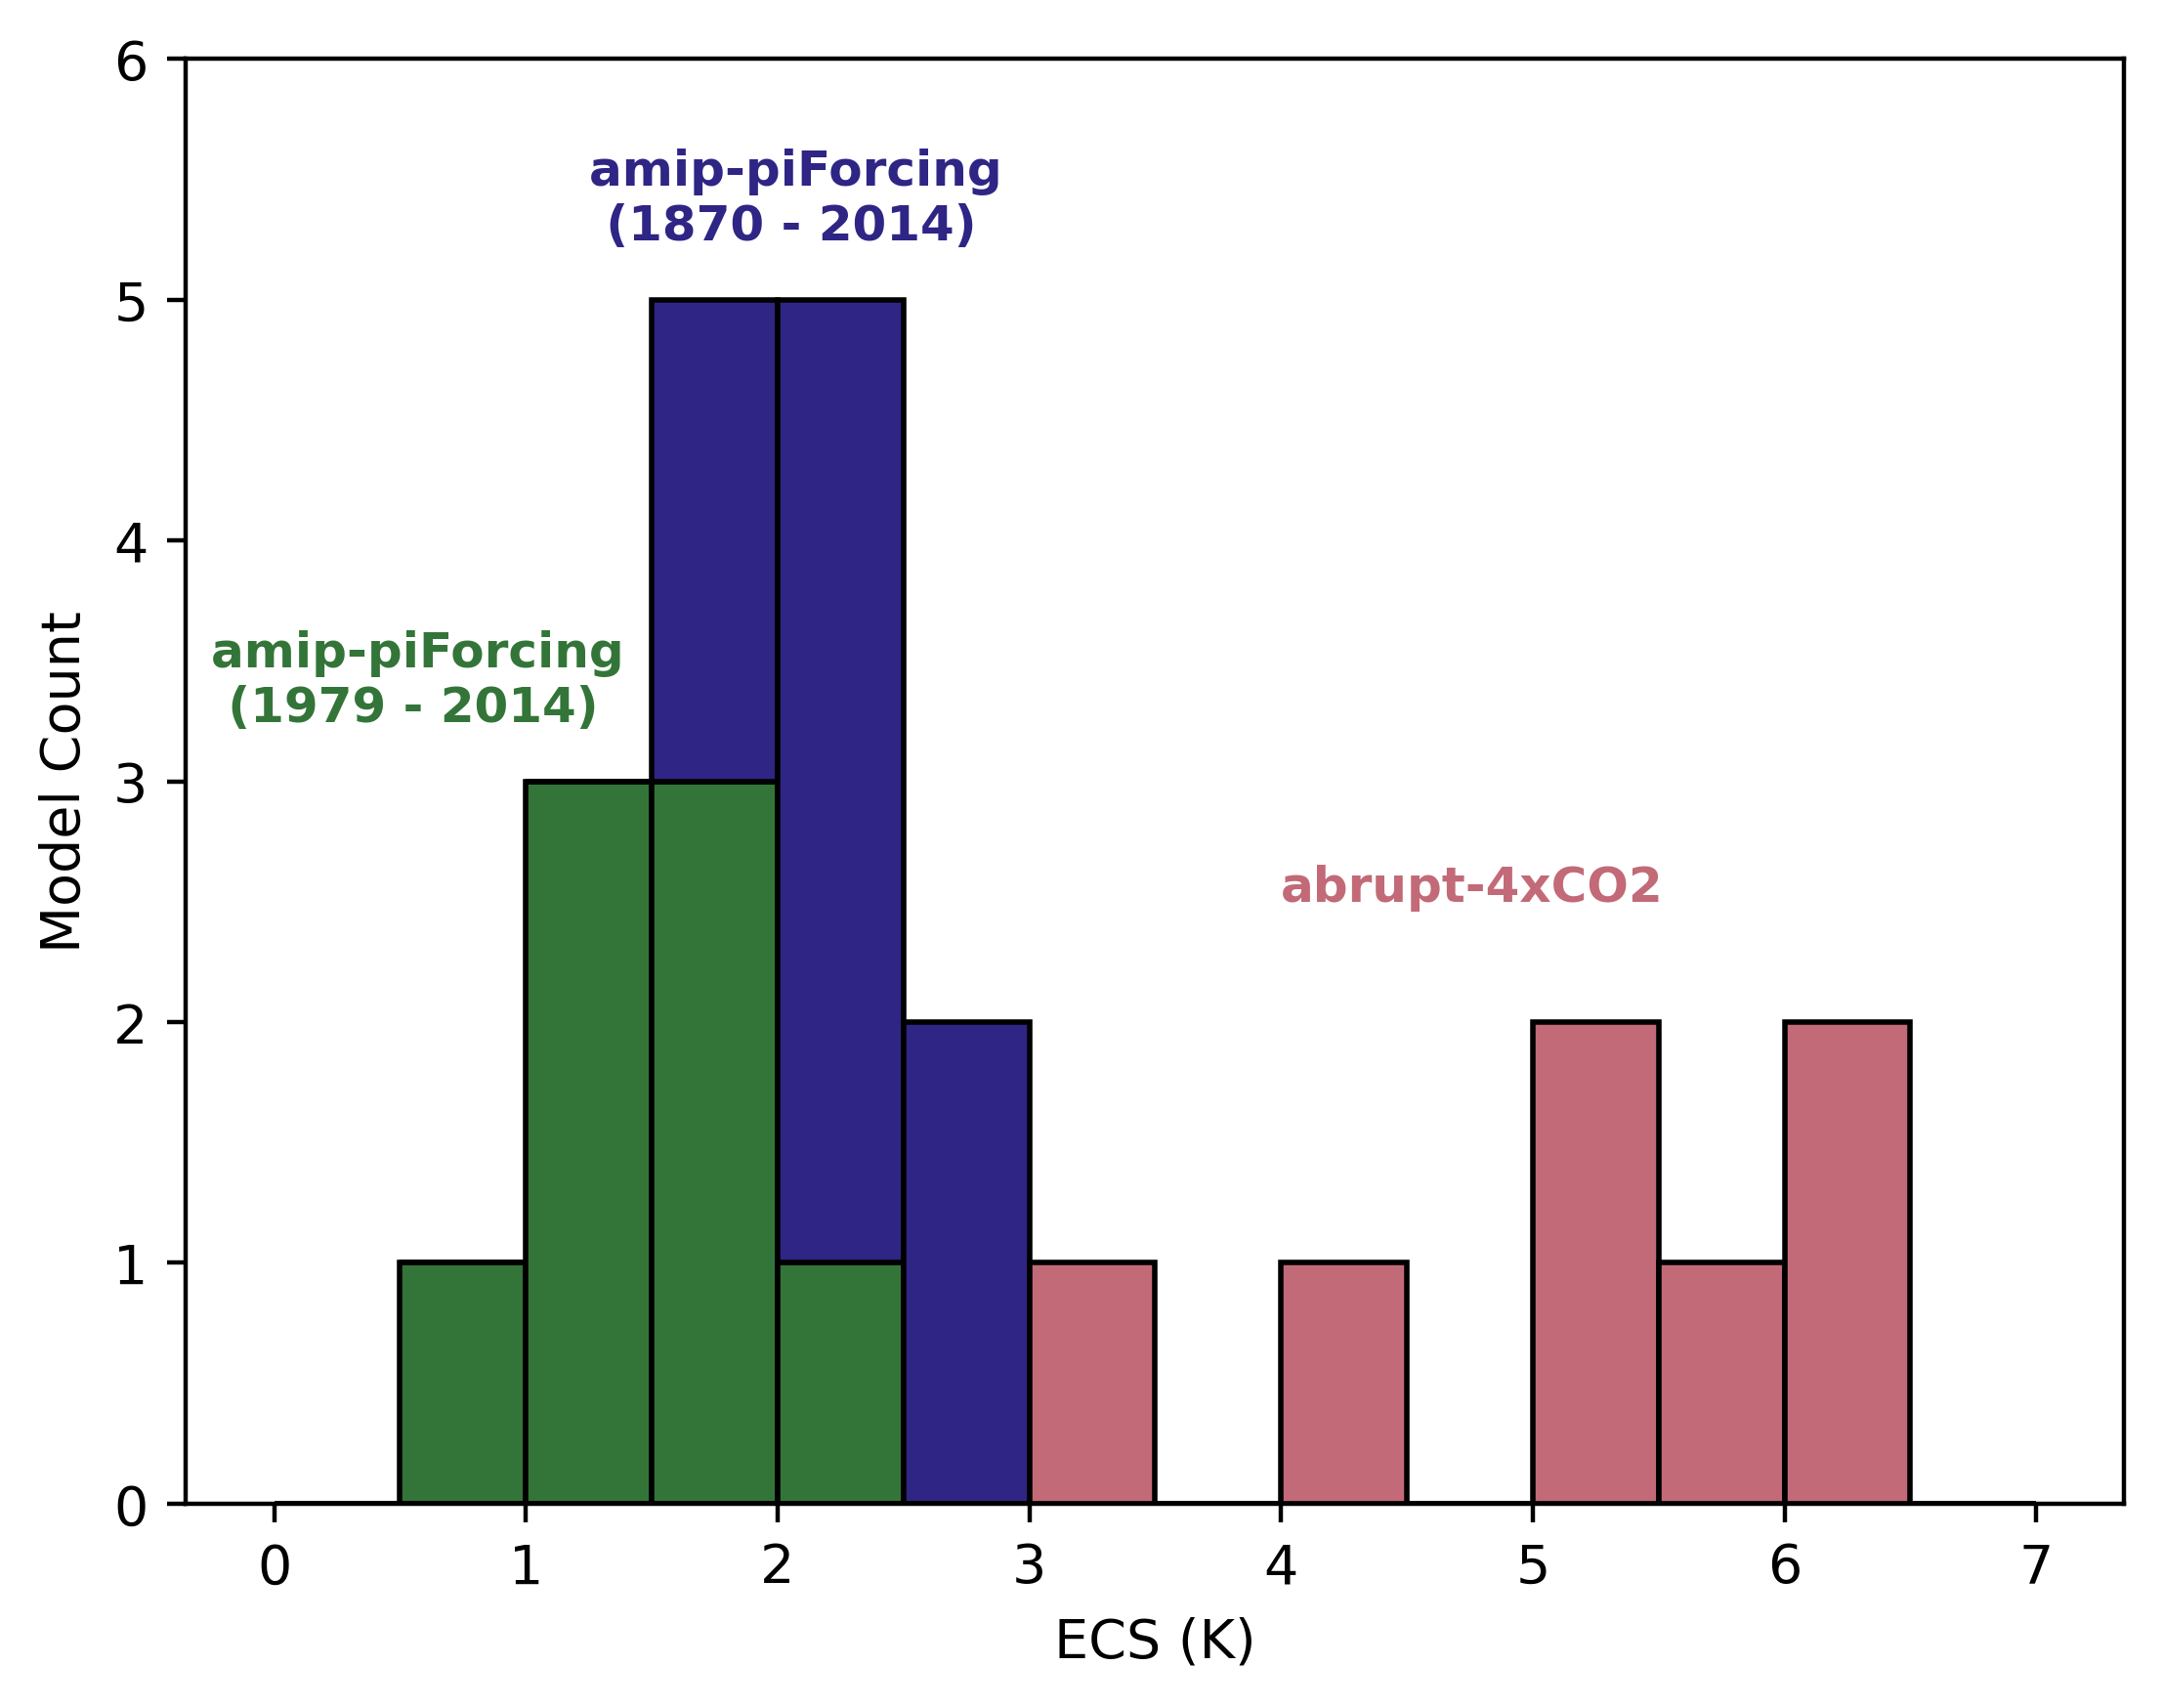

In [56]:
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/code/make_ecs_plot.ipynb

### Bayesian Correlation Plots 

These plots are used to demonstrate the emergent constraint between ENSO feedbacks and model pattern effects.

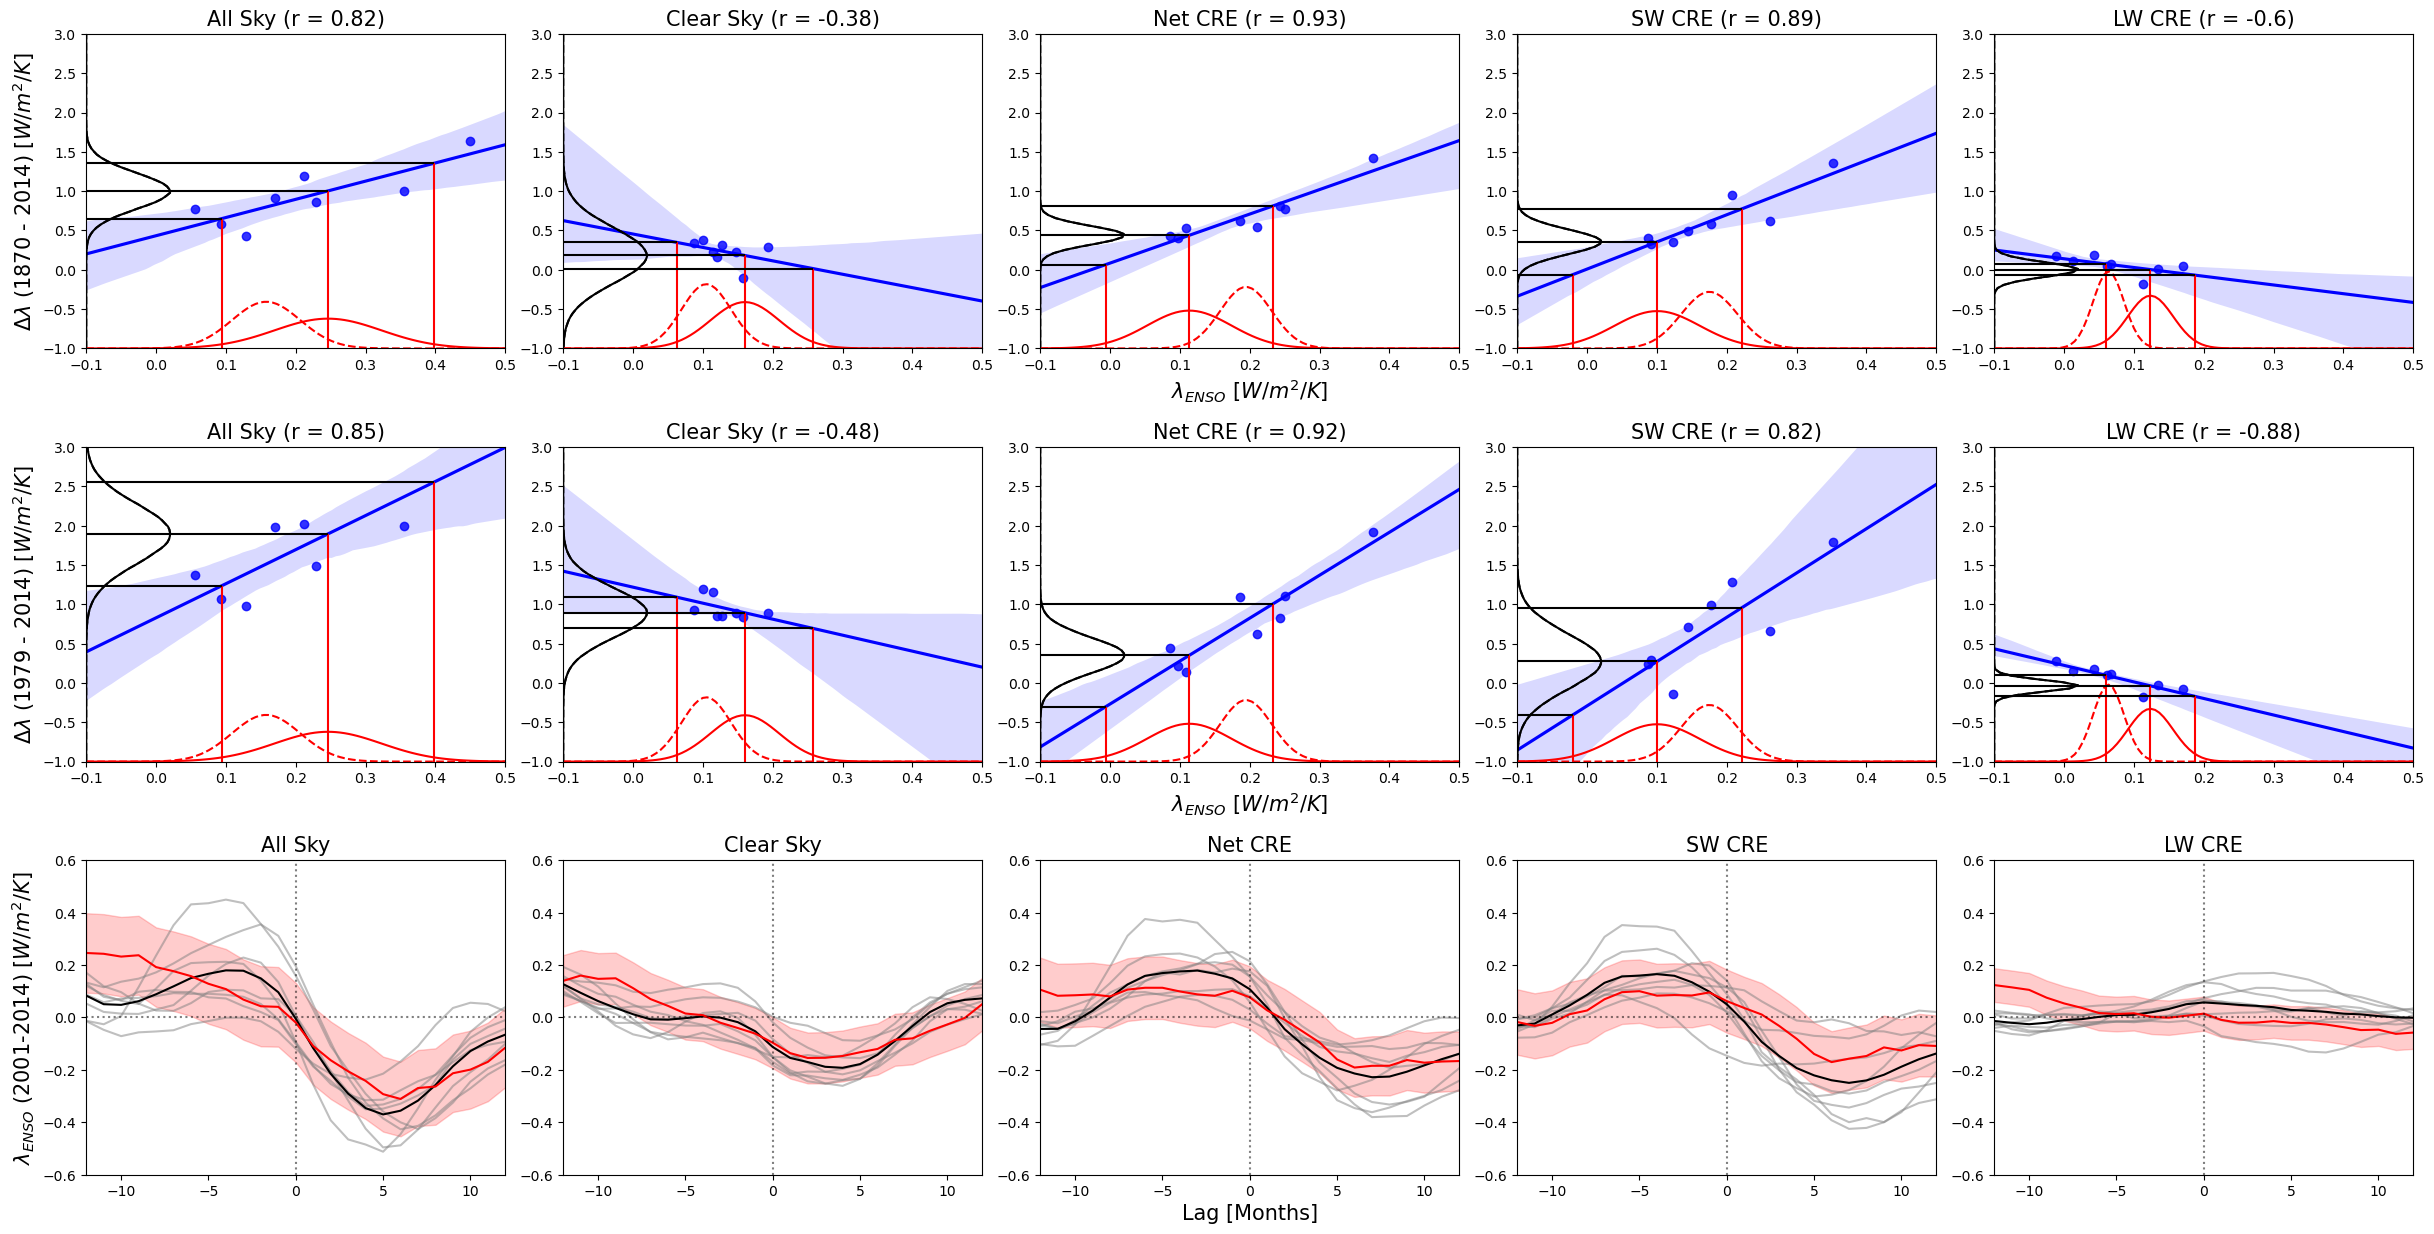

In [11]:
## Get probability densities / kernel densities for each feedback type
data_var = ['all_sky','clr_sky','net_cre','sw_cre','lw_cre']
data_var_ci = ['all_sky_ci','clr_sky_ci','net_cre_ci','sw_cre_ci','lw_cre_ci']

emer_const_mode = True # True = run code to calculate pdf/kde, False = just plot
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/code/make_emer_const_plot.ipynb

### Spatial Maps

In [12]:
plots = ['eq','hist1870','hist1979','diff1870','diff1979','enso','obs']
maps2plot = xr.concat([ds_a.mean(dim='model'), # equilibrium maps
                       ds_h_1870.mean(dim='model'), # historical maps (1870 - 2014)
                       ds_h_1979.mean(dim='model'), # historical maps (1979 - 2014)
                       (ds_a-ds_h_1870).mean(dim='model'), # pattern effect (1870 - 2014)
                       (ds_a-ds_h_1979).mean(dim='model'), # pattern effect (1979 - 2014)
                       ds_e_max.mean(dim='model'), # maximum model ENSO feedback
                       ds_eo_2014_max],dim='plots',coords='minimal',compat='override').assign_coords({'plots':plots})

# convert from xarray dataarray to dataset
maps2plot = maps2plot[['surf_temp','all_sky','net_cre']].to_array().to_dataset(dim='plots')

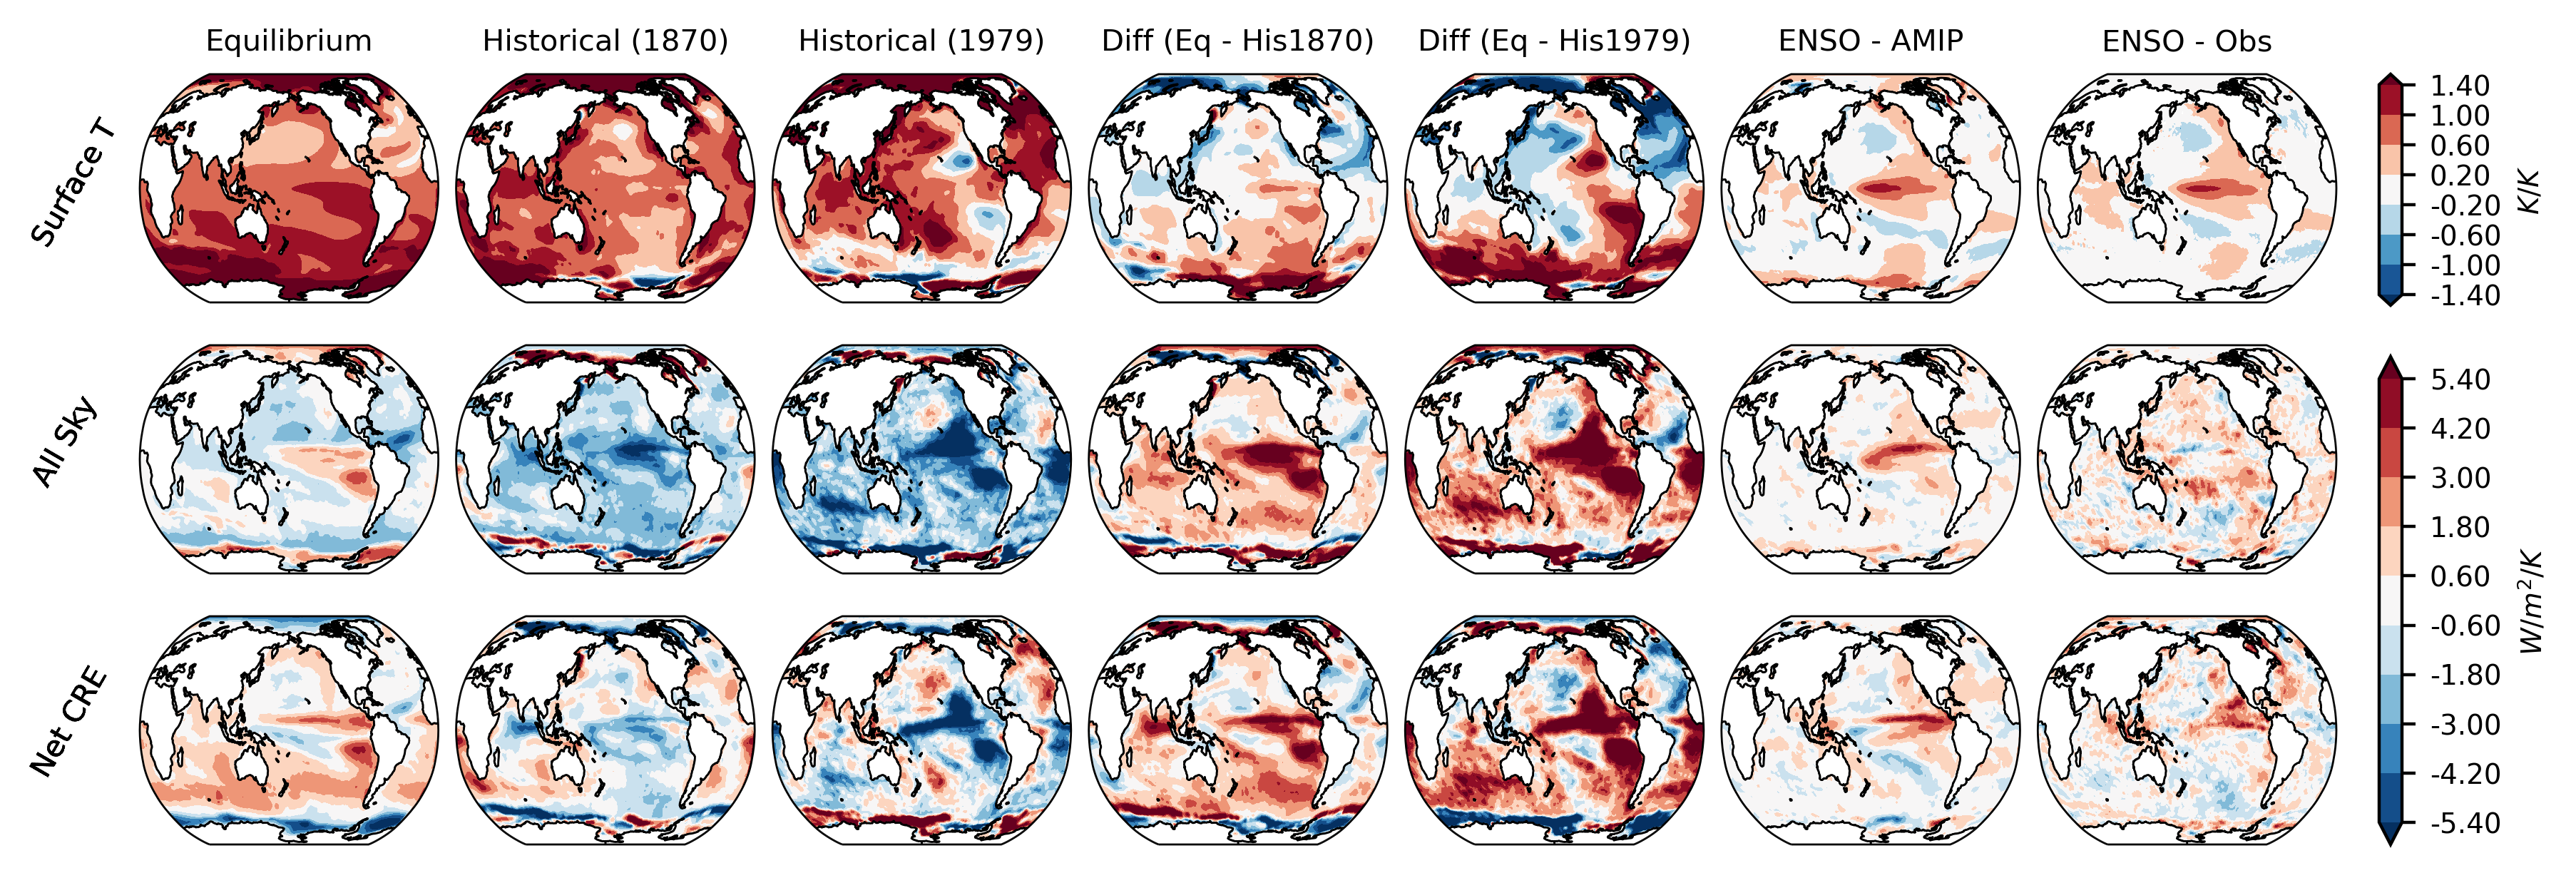

In [13]:
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/code/make_spatial_pattern_plots.ipynb

# Net CRE ONLY

This plot is used to demonstrate the net cloud pattern effects and net cloud ENSO feedbacks for each model, and then compare to the net cloud feedback derived from observations.

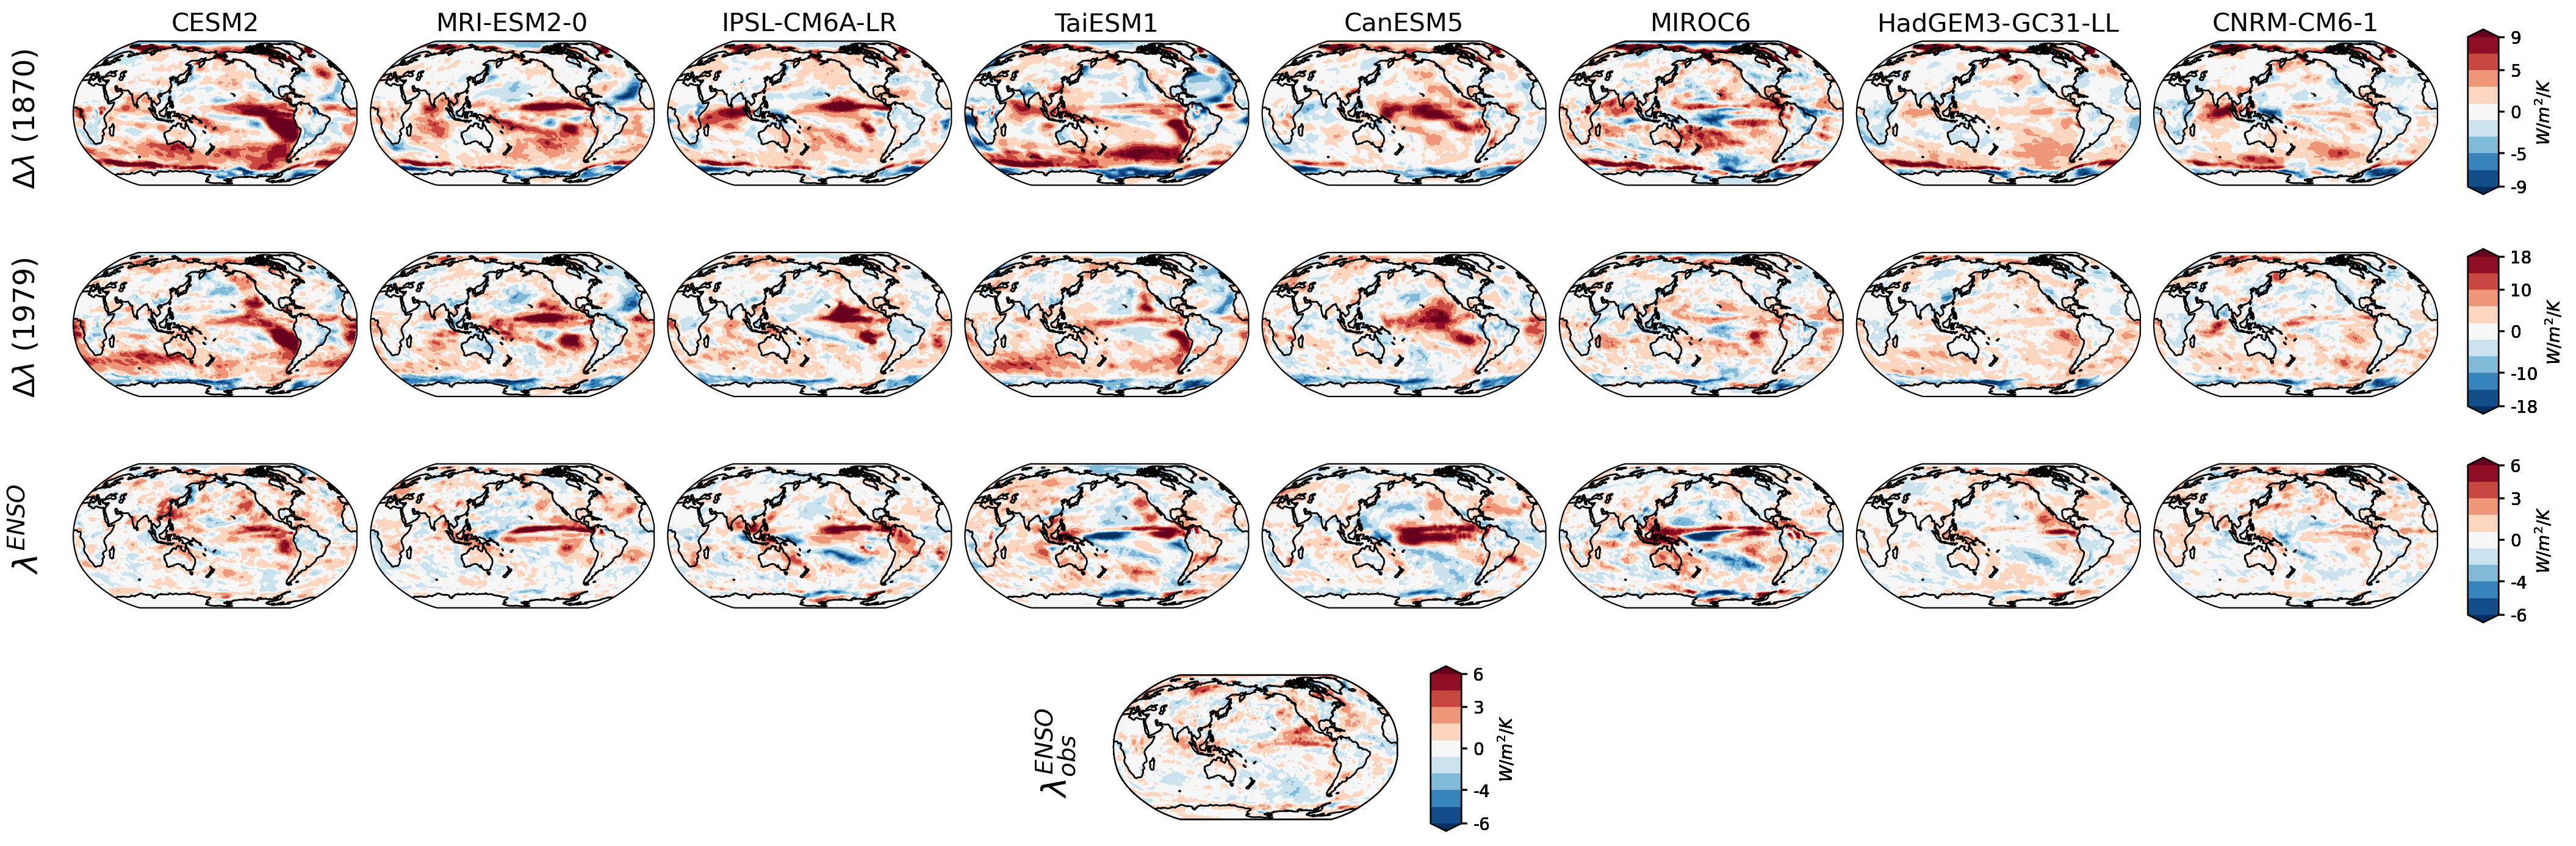

In [14]:
%run /data/keeling/a/tjhanke2/enso-as-an-emergent-constraint/code/make_net_cre_spatial_pattern_plots.ipynb